In [1]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx

def _set_paths() -> None:
    # set the correct path when launched from within PyCharm

    module_paths = ["pytools", "facet", "sklearndf"]

    import sys
    import os
    
    if 'cwd' not in globals():
        # noinspection PyGlobalUndefined
        global cwd
        cwd = os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir)
        os.chdir(cwd)   
    print(f"working dir is '{os.getcwd()}'")
    for module_path in module_paths:
        if module_path not in sys.path:
            sys.path.insert(0, os.path.abspath(f"{cwd}/{os.pardir}/{module_path}/src"))
        print(f"added `{sys.path[0]}` to python paths")
        
def _ignore_warnings():
    # ignore irrelevant warnings that would affect the output of this tutorial notebook
    
    # ignore a useless LGBM warning
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, message=r".*Xcode_8\.3\.3")

_set_paths()
_ignore_warnings()

del _set_paths, _ignore_warnings

working dir is 'C:\Projects\facet\facet'
added `C:\Projects\facet\pytools\src` to python paths
added `C:\Projects\facet\facet\src` to python paths
added `C:\Projects\facet\sklearndf\src` to python paths


In [2]:
# Standard imports
import numpy as np
import pandas as pd
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
import shap

# facet imports - WORKS
from facet import Sample
from facet.inspection import LearnerInspector
from facet.selection import LearnerRanker, LearnerGrid
from facet.validation import BootstrapCV
from facet.simulation.partition import ContinuousRangePartitioner
from facet.simulation import UnivariateUpliftSimulator
from facet.simulation.viz import SimulationDrawer

# sklearndf imports - WORKS
from sklearndf.pipeline import PipelineDF, ClassifierPipelineDF
from sklearndf.classification import (
    GradientBoostingClassifierDF,
    RandomForestClassifierDF,
    LinearDiscriminantAnalysisDF,
    LogisticRegressionDF,
    LinearSVCDF
)
from sklearndf.classification.extra import LGBMClassifierDF
from sklearndf.transformation import (
    ColumnTransformerDF,
    OneHotEncoderDF,
    SimpleImputerDF,
)
from sklearndf.transformation.extra import BorutaDF

# pytools - WORKS
from pytools.viz.dendrogram import DendrogramDrawer, LinkageTree
from pytools.viz.matrix import MatrixDrawer

# couple of extra packages to make EDA easier
import seaborn as sns
from tableone import TableOne

In [3]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx

import warnings
warnings.filterwarnings('ignore')

def _configure_matplotlib():
    # set global options for matplotlib
    
    import matplotlib
    
    matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)
    matplotlib.rcParams['figure.dpi'] = 72

_configure_matplotlib()

del _configure_matplotlib

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


# Background

**Introduction**  
Prediabetes is a treatable condition that leads to many health complications, including eventually type 2 diabetes. Prediabetes has become an epidemic worldwide and is increasing in prevalence. Due to being a largely asymptomatic condition, screening for prediabetes can be extremely challenging. However, early intervention, especially with lifestyle changes has been shown as effective in treating prediabetes. Accurate prediction/identification of those individuals at risk of prediabetes can improve early intervention and may provide insights into those interventions that work best. The current standard of care is a CDC prediabetes risk screening tool (https://www.cdc.gov/diabetes/prevention/pdf/Prediabetes-Risk-Test-Final.pdf). 

**Data source**  
The dataset used in this tutorial is derived from the National Health and Nutrition Examination Survey (NHANES) 2013-14 cross-sectional survey. In brief, NHANES collects demographic, socioeconomic, dietary, health, medical, dental, physiological and laboratory data on a nationally representative sample of noninstitutionalized, civilian United States residents (for more information please visit: https://wwwn.cdc.gov/nchs/nhanes/Search/DataPage.aspx?Component=Examination&CycleBeginYear=2013). Please note the set-up for this data loosely follows the approach in De Silva et al (https://pubmed.ncbi.nlm.nih.gov/31889178/).

**Patient cohort**  
In the NHANES data sub-sets of those surveyed may undergo a plasma glucose (FPG) test, oral glucose tolerance
test (OGTT), or have glycated hemoglobin (HbA1c) measured. Diabetic patients were defined as those with any of the following: FPG >= 126 mg/dl, OGTT > 200 mg/dl, HbA1c > 6.4% or a Doctor diangosed diabetes. The created dataset contains selected information for 4356 patients aged 20 years or over who were not considered diabetic or who were not pregnant or suspected to be pregnant at the time of the survey.

**Learning target: prediabetes status**  
Using any of the available FPG, OGTT and HbA1c tests we defined patients as pre-diabetic where any of the following was satisfied: FPG 100–125 mg/dl, OGTT 140–200 mg/dl, or HbA1c 5.7–6.4%. Among this cohort 35% were pre-diabetic (n=1509).

**Initial features**  
The following tables provides an overview of the 37 features included in the example dataset.

|Instrument	|Data File Name (File)	| NHANES Field	| Description | Dataset name | Type |
| :-- | :-- | :-- | :-- | :-- | :-- |
|Demographics|Demographic Variables, Sample Weights (DEMO_H)|RIDAGEYR|Age in years at screening|Age|Numeric|
|Demographics|Demographic Variables, Sample Weights (DEMO_H)|RIAGENDR|Gender|Gender| Categorical|
|Examination|Body Measures (BMX_H)|BMXWT|Weight (kg)|Weight|Numeric|
|Examination|Body Measures (BMX_H)|BMXHT|Standing Height (cm)|Standing_Height|Numeric|
|Examination|Body Measures (BMX_H)|BMXWAIST|Waist Circumference (cm)|Waist_Circumference|Numeric|
|Examination|Body Measures (BMX_H)|BMXBMI|Body Mass Index (kg/m^2)|BMI|Numeric|
|Examination|Blood Pressure (BPX_H)|BPXSY1 to 4|Systolic: Blood pres mm Hg|Average_SBP| Numeric|
|Examination|Blood Pressure (BPX_H)|BPXDI1 to 4|Diastolic: Blood pres mm Hg|Average_DBP| Numeric|
|Questionnaire|Blood Pressure & Cholesterol (BPQ_H)|BPQ020|Ever told you had high blood pressure|High_BP| Categorical|
|Questionnaire|Diet Behavior & Nutrition (DBQ_H)|DBQ700|How healthy is the diet|Healthy_diet| Categorical|
|Questionnaire|Diabetes (DIQ_H)|DIQ175A|Family history|Family_hist_diab| Categorical|
|Questionnaire|Diabetes (DIQ_H)|DIQ172|Feel could be at risk for diabetes|Feel_at_risk_diab| Categorical|
|Questionnaire|Current Health Status (HSQ_H)|HSD010|General health condition|General_health| Categorical|
|Questionnaire|Medical Conditions (MCQ_H)|MCQ080|Doctor ever said you were overweight|Told_overweight| Categorical|
|Questionnaire|Physical Activity (PAQ_H)|PAQ605|Vigorous work activity|Vigorous_work_activity| Categorical|
|Questionnaire|Physical Activity (PAQ_H)|PAQ620|Moderate work activity|Moderate_work_activity| Categorical|
|Questionnaire|Physical Activity (PAQ_H)|PAQ635|Walk or bicycle|Walk_or_bicycle| Categorical|
|Questionnaire|Physical Activity (PAQ_H)|PAQ650|Vigorous recreational activities|Vigorous_rec_activity| Categorical|
|Questionnaire|Physical Activity (PAQ_H)|PAQ665|Moderate recreational activities|Moderate_rec_activity| Categorical|
|Questionnaire|Sleep Disorders (SLQ_H)|SLD010H|How much sleep do you get (hours)?|Sleep_hours| Numeric|
|Questionnaire|Sleep Disorders (SLQ_H)|SLQ050|Ever told doctor had trouble sleeping?|Trouble_sleeping| Categorical|
|Questionnaire|Sleep Disorders (SLQ_H)|SLQ060|Ever told by doctor have sleep disorder?|Sleep_disorder| Categorical|
|Questionnaire|Weight History (WHQ_H)|WHQ070|Tried to lose weight in past year|Tried_weight_loss_past_year| Categorical|
|Laboratory|Cholesterol HDL (HDL_H)|LBDHDD|Direct HDL-Cholesterol (mg/dL)|HDL_Cholesterol| Numeric|
|Laboratory|Cholesterol Total (TCHOL_H)|LBXTC|Total Cholesterol(mg/dL)|Total_Cholesterol| Numeric|
|Laboratory|Complete Blood Count (CBC_H)|LBXWBCSI|White blood cell count (1000 cells/uL)|WBC_count| Numeric|
|Laboratory|Complete Blood Count (CBC_H)|LBXRBCSI|Red blood cell count (million cells/uL)|RBC_count| Numeric|
|Laboratory|Complete Blood Count (CBC_H)|LBXHCT|Hematocrit (%)|Hematocrit| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSTR|Triglycerides (mg/dL)|Triglycerides| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSUA|Uric acid (mg/dL)|Uric_acid| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSOSSI|Osmolality (mmol/Kg)|Osmolality| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSNASI|Sodium (mmol/L)|Sodium| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSKSI|Potassium (mmol/L)|Potassium| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSGTSI|Gamma glutamyl transferase (U/L)|Gamma_glutamyl_transferase| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSCA|Total calcium (mg/dL)|Calcium| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSATSI|Alanine aminotransferase ALT (IU/L)|Alanine_aminotransferase| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSASSI|Aspartate aminotransferase AST (IU/L)|Aspartate_aminotransferase| Numeric|

# EDA

Let's begin by doing some brief exploratory data anaylsis to assess the impact features might have on the likelihood someone is pre-diabetic and to also determine what will need to be addressed in a pre-processing pipeline.

In [5]:
# load the prepared dataframe
prediab_df = pd.read_csv('sphinx/source/tutorial/pre_diab_nhanes.csv')
prediab_df.head()

,Age,Gender,Waist_Circumference,Weight,Standing_Height,BMI,Average_SBP,Average_DBP,HDL_Cholesterol,Total_Cholesterol,...,Triglycerides,Uric_acid,Osmolality,Sodium,Potassium,Gamma_glutamyl_transferase,Calcium,Alanine_aminotransferase,Aspartate_aminotransferase,Pre_diab
0,73.0,2.0,NaN,52.0,162.4,19.7,137.333333,86.666667,85.0,201.0,...,88.0,4.2,290.0,142.0,4.1,31.0,10.0,28.0,36.0,1
1,56.0,1.0,123.1,105.0,158.7,41.7,157.333333,82.000000,38.0,226.0,...,327.0,9.1,287.0,143.0,3.3,22.0,9.3,16.0,24.0,0
2,61.0,2.0,110.8,93.4,161.8,35.7,122.666667,80.666667,58.0,168.0,...,68.0,5.1,281.0,140.0,3.9,17.0,9.9,21.0,20.0,1
3,56.0,2.0,85.5,61.8,152.8,26.5,122.000000,72.666667,59.0,278.0,...,262.0,3.5,277.0,139.0,4.0,21.0,9.5,24.0,23.0,0
4,65.0,1.0,93.7,65.3,172.4,22.0,141.333333,77.333333,79.0,173.0,...,39.0,6.3,281.0,140.0,4.8,24.0,9.5,20.0,29.0,0


We might also consider some rudimentary feature engineering as well, such as the ratio of waist circumference to height or the ratio of systolic to diastolic blood pressure. Let's create these two features as well.

In [7]:
prediab_df['SBP_to_DBP'] = prediab_df['Average_SBP']/prediab_df['Average_DBP']
prediab_df['Waist_to_hgt'] = prediab_df['Waist_Circumference']/prediab_df['Standing_Height']
prediab_df.head()

,Age,Gender,Waist_Circumference,Weight,Standing_Height,BMI,Average_SBP,Average_DBP,HDL_Cholesterol,Total_Cholesterol,...,Osmolality,Sodium,Potassium,Gamma_glutamyl_transferase,Calcium,Alanine_aminotransferase,Aspartate_aminotransferase,Pre_diab,SBP_to_DBP,Waist_to_hgt
0,73.0,2.0,NaN,52.0,162.4,19.7,137.333333,86.666667,85.0,201.0,...,290.0,142.0,4.1,31.0,10.0,28.0,36.0,1,1.584615,NaN
1,56.0,1.0,123.1,105.0,158.7,41.7,157.333333,82.000000,38.0,226.0,...,287.0,143.0,3.3,22.0,9.3,16.0,24.0,0,1.918699,0.775677
2,61.0,2.0,110.8,93.4,161.8,35.7,122.666667,80.666667,58.0,168.0,...,281.0,140.0,3.9,17.0,9.9,21.0,20.0,1,1.520661,0.684796
3,56.0,2.0,85.5,61.8,152.8,26.5,122.000000,72.666667,59.0,278.0,...,277.0,139.0,4.0,21.0,9.5,24.0,23.0,0,1.678899,0.559555
4,65.0,1.0,93.7,65.3,172.4,22.0,141.333333,77.333333,79.0,173.0,...,281.0,140.0,4.8,24.0,9.5,20.0,29.0,0,1.827586,0.543503


In [8]:
# First a quick look at features overall - remove .head() to see all features
prediab_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,4356.0,47.044536,17.188703,20.000000,33.000000,45.000000,61.000000,80.000000
Gender,4356.0,1.521350,0.499601,1.000000,1.000000,2.000000,2.000000,2.000000
Waist_Circumference,4158.0,97.167268,15.799909,55.500000,85.900000,95.500000,106.500000,177.900000
Weight,4321.0,79.939968,21.135093,32.300000,65.100000,76.900000,91.100000,222.600000
Standing_Height,4318.0,167.369701,10.158315,136.300000,160.000000,167.100000,174.500000,199.400000
BMI,4314.0,28.446639,6.793577,14.100000,23.700000,27.300000,31.800000,82.900000
Average_SBP,4229.0,121.893671,17.271841,64.666667,110.000000,118.666667,131.333333,228.000000
Average_DBP,4222.0,70.280515,11.039221,22.666667,63.333333,70.666667,77.333333,128.000000
HDL_Cholesterol,4318.0,53.723020,16.240125,10.000000,42.000000,51.000000,63.000000,173.000000
Total_Cholesterol,4318.0,190.363131,39.631288,69.000000,163.000000,188.000000,214.000000,525.000000


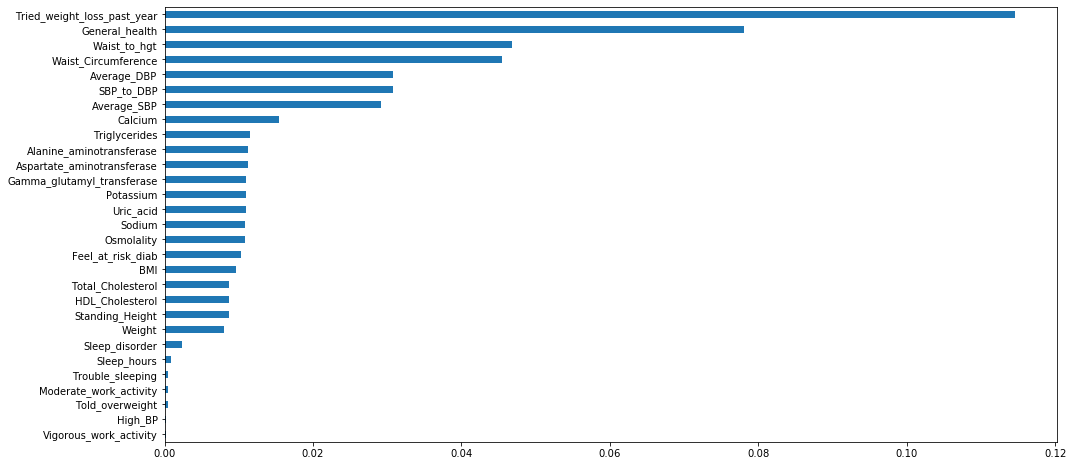

In [9]:
# Missingness
miss_count = prediab_df.isna().sum()
miss_pct = miss_count[miss_count>0]/len(prediab_df)
miss_pct.sort_values().plot.barh()

In [10]:
# those variables that are complete
miss_count[miss_count==0]/len(prediab_df)

Age                      0.0
Gender                   0.0
Family_hist_diab         0.0
Walk_or_bicycle          0.0
Vigorous_rec_activity    0.0
Moderate_rec_activity    0.0
Healthy_diet             0.0
WBC_count                0.0
RBC_count                0.0
Hematocrit               0.0
Pre_diab                 0.0
dtype: float64

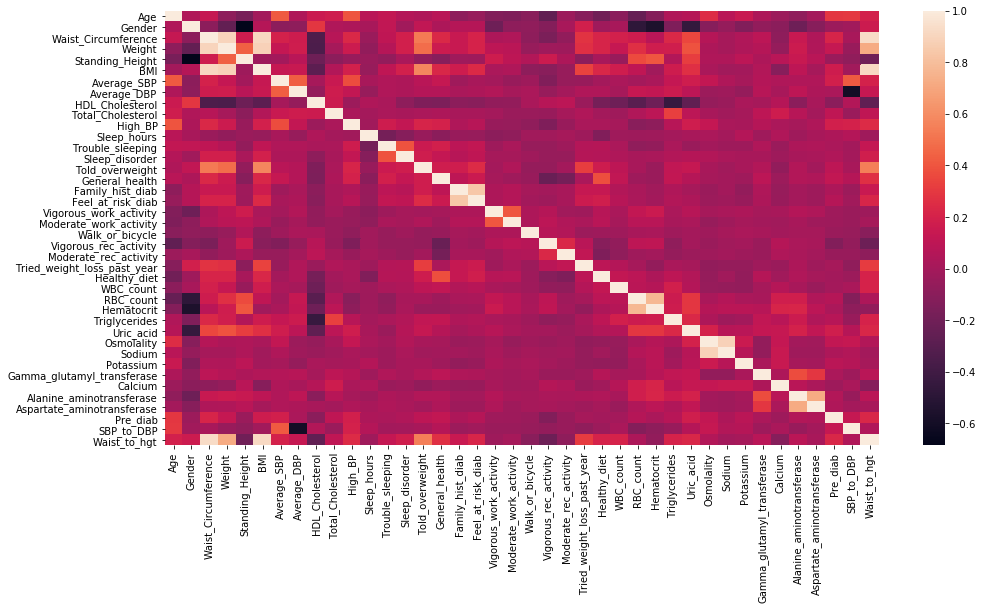

In [11]:
# Look at correlations
# Heatmap view
df_cor = prediab_df.corr()
sns.heatmap(df_cor, 
            xticklabels=df_cor.columns,
            yticklabels=df_cor.columns)

In [12]:
# Let's do a table comparing features by the target
categorical = ['Gender', 'High_BP', 'Trouble_sleeping', 'Sleep_disorder', 'Told_overweight', 'General_health',
               'Family_hist_diab', 'Feel_at_risk_diab', 'Vigorous_work_activity', 'Moderate_work_activity',
               'Walk_or_bicycle', 'Vigorous_rec_activity', 'Moderate_rec_activity', 'Tried_weight_loss_past_year',
               'Healthy_diet']

mytable = TableOne(prediab_df,
                   columns=prediab_df.columns.drop('Pre_diab').to_list(),
                   categorical=categorical,
                   groupby='Pre_diab',
                   pval=True,
                   remarks=False,
                   overall=False)
print(mytable)

                                          Grouped by Pre_diab                                     
                                                      Missing             0              1 P-Value
n                                                                      2847           1509        
Age, mean (SD)                                              0   43.4 (16.4)    54.0 (16.4)  <0.001
Gender, n (%)                         1.0                   0   1330 (46.7)     755 (50.0)   0.040
                                      2.0                       1517 (53.3)     754 (50.0)        
Waist_Circumference, mean (SD)                            198   94.7 (15.3)   101.9 (15.7)  <0.001
Weight, mean (SD)                                          35   77.8 (20.2)    83.9 (22.2)  <0.001
Standing_Height, mean (SD)                                 38  167.6 (10.1)   166.8 (10.2)   0.014
BMI, mean (SD)                                             42    27.6 (6.4)     30.0 (7.2)  <0.001
Average_SB

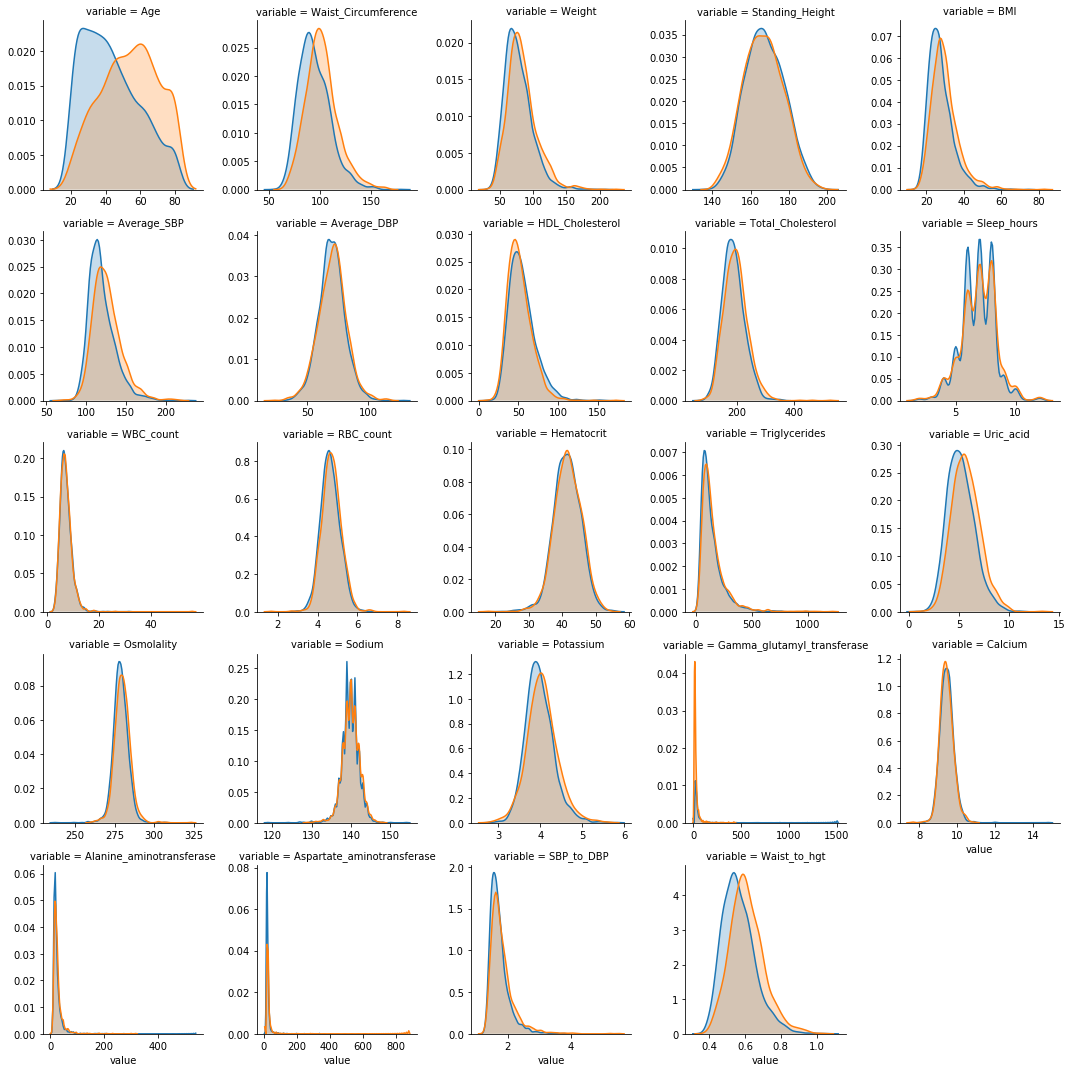

In [13]:
# KDE plots by prediabetes status as well for those continuous features
distn_vars = ['Age', 'Waist_Circumference', 'Weight', 'Standing_Height', 'BMI', 'Average_SBP', 'Average_DBP',
              'HDL_Cholesterol', 'Total_Cholesterol', 'Sleep_hours',  'WBC_count', 'RBC_count', 'Hematocrit',
              'Triglycerides', 'Uric_acid', 'Osmolality', 'Sodium', 'Potassium', 'Gamma_glutamyl_transferase',
              'Calcium', 'Alanine_aminotransferase', 'Aspartate_aminotransferase', 'SBP_to_DBP', 'Waist_to_hgt']

df_kde = pd.melt(prediab_df[distn_vars + ['Pre_diab']], 'Pre_diab', distn_vars)
g = sns.FacetGrid(df_kde, col="variable", hue="Pre_diab", col_wrap=5, sharex=False, sharey=False)
g.map(sns.kdeplot, "value", shade=True)
plt.show()

**Quick EDA summary:**

Missingness

- Our target and 10 features were complete.
- The other 29 features had levels of missing ranging from 0.02% to 11.5%, and 22 of the 29 were <3%.
- Most extreme cases of missingness were for tried weight loss in the past year (11.5%) and general health (7.8%).

Correlations

- There is a wide range of correlation among features, where in particular we can see that for example RBC count, hematocrit and standing height are all moderately negatively correlated with gender (i.e., females are shorter), and that body measurements for weight, height, BMI, and waist circumference are all strongly positively correlated. 

Associations

- Some features already appear to not to be strongly associated based on univariate tests, such as: average DBP, trouble sleeping, vigorous work activity, moderate work activity, tried weight loss in the past year, healthy diet, WBC count, and calcium levels.
- Features associated with an increased risk of prediabetes include: older age, being male, increased waist circumference, decreased standing height, increased weight, increased BMI, increased average SBP, lower HDL cholesterol, increased total cholesterol, having high BP, increased sleep hours, having a sleep disorder, being told you are overweight, poorer general health, family history of diabetes, feeling at risk for diabetes, reduced walking or cycling, less vigorous or moderate recreational activity, higher RBC count, higher hematocrit, increased triglycerides, increased uric acid, higher osmolality, increased sodium, increased potassium, increased gamma glutamyl transferase, increased alanine aminotransferase, increased aspartate aminotransferase, increased SBP to DBP ratio, increased waist to height ratio.

Distributions of numeric features

- Many of the continuous features have been flagged as potentially non-normal/multi-modal and with potential outliers. This can be seen in the plots where many biomarkers have positive skewed distributions and in the case of sodium, some modality which could also be related to measurement.

In [14]:
# make clear based on dtypes these are categorical
prediab_df['General_health'] = prediab_df['General_health'].astype('object')
prediab_df['Healthy_diet'] = prediab_df['Healthy_diet'].astype('object')

# Creating a pre-processing pipeline

Using Facet we first create a dataset object, which carries information used in other Facet functions.

In [15]:
# Create sample object
prediab = Sample(
    observations=prediab_df,
    features=prediab_df.drop(columns=['Pre_diab']).columns,
    target='Pre_diab'
)

Now we create a minimum pre-processing pipeline which needs to address the following:

1. Simple imputation for missing values in both continuous and categorical features
2. One-hot encoding for the catgeorical features

In [16]:
# for categorical features we will use the mode as the imputation value and also one-hot encode
preprocessing_categorical = PipelineDF(
    steps=[
        ("imputer", SimpleImputerDF(strategy="most_frequent", fill_value="<na>")), 
        ("one-hot", OneHotEncoderDF(sparse=False, handle_unknown="ignore"))
    ]
)

# for numeric features we will impute using the median
preprocessing_numerical = SimpleImputerDF(strategy="median")

# put the piepline together
preprocessing = ColumnTransformerDF(
    transformers=[
        ('categorical', preprocessing_categorical, prediab.features.select_dtypes(object).columns),
        ('numerical', preprocessing_numerical, prediab.features.select_dtypes(np.number).columns)
    ]
)

# Initial feature selection using Boruta

There are many approaches to feature selection, however a somewhat recent approach called Boruta has shown to have quite good performance. The Boruta algorithm removes features that are no more predictive than random noise. If you are interested further please see: https://www.jstatsoft.org/article/view/v036i11. 

For settings, a max_depth of between 3 and 7 is typically recommended. However, as this depends on the number of features and the complexity of interactions one could also explore the sensitivity of feature selection to this parameter.

In [17]:
boruta_pipeline = PipelineDF(
    steps=[
        ('preprocess', preprocessing),
        ('boruta', BorutaDF(
            estimator=RandomForestClassifierDF(max_depth=5, n_jobs=-3, random_state=42), 
            n_estimators="auto", 
            random_state=42,
            verbose=False
        )),
    ]
)

boruta_pipeline.fit(X=prediab.features, y=prediab.target)
selected = boruta_pipeline.features_out.to_list()
selected

['Age',
 'Waist_Circumference',
 'Weight',
 'Standing_Height',
 'BMI',
 'Average_SBP',
 'Average_DBP',
 'HDL_Cholesterol',
 'Total_Cholesterol',
 'High_BP',
 'Vigorous_rec_activity',
 'RBC_count',
 'Uric_acid',
 'Osmolality',
 'Potassium',
 'Gamma_glutamyl_transferase',
 'Alanine_aminotransferase',
 'SBP_to_DBP',
 'Waist_to_hgt']

Boruta identified 19 features (out of a potential 47) that we will utilize in our learner development. Note that this feature selection process could be included in a general pre-processing pipeline, however due to the computation involved, we utilize Boruta here as an initial one-off processing step to narrow down the features for our classifier development.

In [18]:
prediab = prediab.keep(selected)

# Selecting a learner using bootstrap cross-validation

Facet implements Bootstrap CV which uses resampling to create a training set. This re-sampling procedure is repeated many times to get an estimate of average model performance and the variability of that performance. This is an important extension of the native scikit-learn cross-validators which do not support sampling with replacement.

The following learners and hyper-parameter ranges will be assessed using the cross-validated bootstrap:


1. **Random forest**: with hyper-parameters
    - max_leaf_nodes: [5, 10, 20]
    - n_estimators: [50, 100, 200]  
  
  
2. **Light gradient boosting**: with hyper-parameters
    - max_depth: [5, 7, 10]
    - num_leaves: [20]
    - learning_rate: [0.2, 0.1, 0.01]
    - subsample: [0.7]
    - feature_fraction:[0.8]

Note if you want to see a list of hyper-parameters you can use `classifier_name().get_params().keys()` where `classifier_name` could be for example `RandomForestClassifierDF` and if you want to see the default values, just use `classifier_name().get_params()`.

Finally, for this exercise we will use AUC as the performance metric for scoring and ranking our classifiers. Note that ranking uses the average performance minus two times the standard deviation, so that we take into account both the average performance and variability when selecting a classifier.

In [19]:
# 1. Random forest learner
rf_pipeline=ClassifierPipelineDF(
    classifier=RandomForestClassifierDF(),
    preprocessing=preprocessing,
)
rf_grid=LearnerGrid(
    pipeline=rf_pipeline,
    learner_parameters={'max_leaf_nodes': [5, 10, 20],
                        'n_estimators': [50, 100, 200]}
)

# 2. Light gradient boosting learner
gb_pipeline=ClassifierPipelineDF(
    classifier=LGBMClassifierDF(),
    preprocessing=preprocessing,
)
gb_grid=LearnerGrid(
    pipeline=gb_pipeline,
    learner_parameters={'max_depth': [5, 10],
                        'num_leaves': [20],
                        'learning_rate': [0.2, 0.1],
                        'subsample': [0.7],
                        'feature_fraction':[0.8]}
)

In [20]:
# Instigate ranker and fit. Note one can use n_splits argument in BootstrapCV to set the number of times we create a 
# re-sampled dataset for training. Please note this may take some time to run.

ranker = LearnerRanker(
    grids=[rf_grid, gb_grid],
    cv=BootstrapCV(random_state=42),
    n_jobs=-3,
    scoring='roc_auc'
).fit(prediab)

ValueError: A given column is not a column of the dataframe

In [67]:
# Let's look at performance
print(ranker.summary_report())

Rank  1: RandomForestClassifierDF, ranking_score=    0.707, scores_mean=    0.728, scores_std=   0.0105, parameters={classifier__max_leaf_nodes=20,classifier__n_estimators=200}

Rank  2: RandomForestClassifierDF, ranking_score=    0.707, scores_mean=    0.728, scores_std=   0.0105, parameters={classifier__max_leaf_nodes=20,classifier__n_estimators=100}

Rank  3: RandomForestClassifierDF, ranking_score=    0.705, scores_mean=    0.726, scores_std=   0.0103, parameters={classifier__max_leaf_nodes=20,classifier__n_estimators=50}

Rank  4:         LGBMClassifierDF, ranking_score=    0.704, scores_mean=    0.724, scores_std=   0.0102, parameters={classifier__max_depth=5,classifier__n_estimators=50,classifier__learning_rate=0.05,classifier__subsample=0.7}

Rank  5:         LGBMClassifierDF, ranking_score=    0.704, scores_mean=    0.724, scores_std=   0.0102, parameters={classifier__max_depth=5,classifier__n_estimators=50,classifier__learning_rate=0.05,classifier__subsample=0.9}

Rank  6:   

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


We can see based on our learner ranker, we have selected a Random Forest algorithm with the tuned hyper-parameters: max_leaf_nodes=20, n_estimators=200 with a mean ROC AUC of 0.73 with a SD of 0.010.

# Using the inspector and SHAP to understand model predictions

The `SHAP approach <http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions>` has become the standard method for model inspection. SHAP values are used to explain the additive contribution of each feature to the prediction for a given observation. SHAP values are computed for every feature and observation.

The Facet `LearnerInspector` computes these SHAP values for each bootstrap resample using the best model identified by the `LearnerRanker`. The Facet `LearnerInspector` then provides advanced model inspection through new SHAP-based summary metrics for understanding feature redundancy and synergy.

Briefly, the definitions are as follows:

1. **Redundancy** represents how much information is shared between two features contributions to model predictions. In our example we might expect redundancy between BMI and waist circumference as a higher BMI will tend to lead to a larger waist circumference and vice versa. This means just knowing one or the other is likely to provide similar predictive performance.
2. **Synergy** represents how much the combined information of two features contributes to the model predictions. In our example we could hypothesize that knowing both gender and BMI provides greater accuracy in predicting prediabetes risk than either alone. 

SHAP values from the `LearnerInspector` can also be used with the SHAP package plotting functions for sample and observation level SHAP visualizations, such as SHAP distribution plots, dependency plots, force plots and waterfall plots.

In [68]:
# run inspector
# TIP: the number used in resize() determines how many of the crossfits to calculate SHAP values for. As SHAP value
# calculation can be time consuming so using a lower value initially can help efficiency before using all crossfits in a
# final run.

inspector = LearnerInspector(
    n_jobs=-3,
    verbose=10,
).fit(
    crossfit=ranker.best_model_crossfit.resize(20)
)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-3)]: Done   6 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-3)]: Done  12 out of  20 | elapsed:  2.7min remaining:  1.8min
[Parallel(n_jobs=-3)]: Done  15 out of  20 | elapsed:  3.5min remaining:  1.2min
[Parallel(n_jobs=-3)]: Done  18 out of  20 | elapsed:  3.7min remaining:   24.7s
[Parallel(n_jobs=-3)]: Done  20 out of  20 | elapsed:  4.1min finished


In [69]:
# obtain Facet feature importance, as well as synergy and redundancy matrices
f_importance = inspector.feature_importance()
redundancy_matrix = inspector.feature_redundancy_matrix()
synergy_matrix = inspector.feature_synergy_matrix()
dd_redundancy = inspector.feature_redundancy_linkage()

# Also let's get some info for standard SHAP plots!
shap_values = inspector.shap_values().to_numpy()
rf_pipeline.preprocessing.fit(X=prediab.features)
X_train = rf_pipeline.preprocessing.transform(X=prediab.features)
X_train = X_train.reset_index()[prediab.features.columns]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


## Feature importance

Feature importance has many different ways of being measured. Here we utilize the Facet implementation based on the `LearnerInspector`. Each feature is ranked according to the mean SHAP value for that feature. With the crossfit object we can also get some sense of the uncertainty in feature importance as well.

This plot is paired with a standard SHAP distribution plot for features to see if there is any directional tendency for the associations.

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


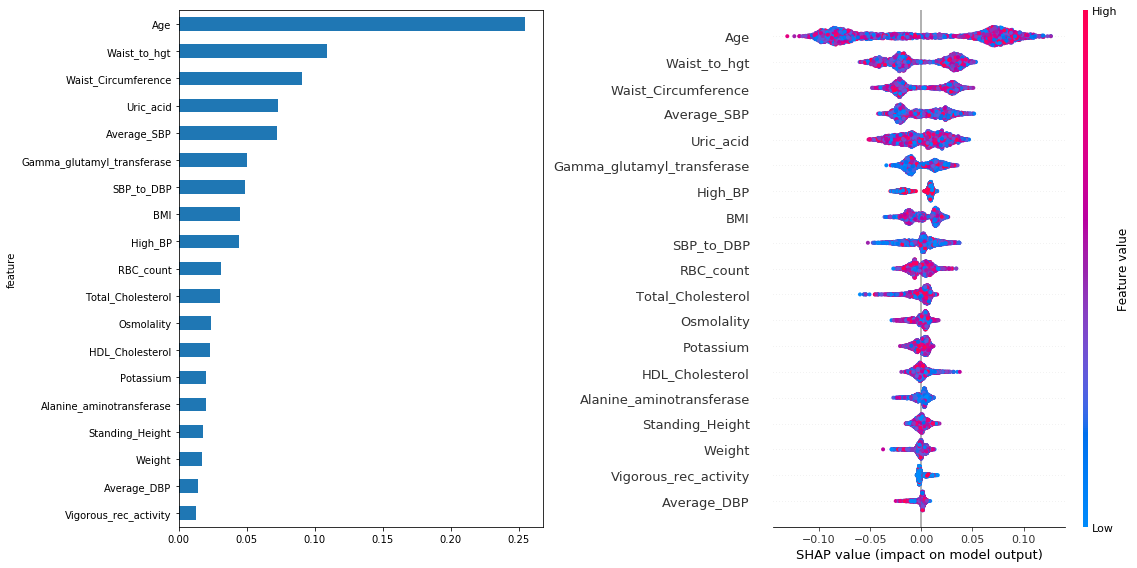

In [70]:
# Facet feature importance
plt.subplot(1, 2, 1)
f_importance.sort_values().plot.barh()

# Standard SHAP summary plot using the SHAP package
plt.subplot(1, 2, 2)
shap.summary_plot(shap_values, X_train, show=False, plot_size=(16.0, 8.0))
plt.tight_layout()

Based on the feature importances we can see the top five features are age, waist to height ratio, waist circumference, uric acid and average systolic blood pressure. Inspection of the SHAP value distributions does not provide any indication of a general direction of association for any features. 

## Redundancy and synergy

Redundancy and synergy are part of the key extensions Facet makes to using SHAP values to understand model predictions. Redundancy represents the shared information between two features and synergy represents the degree to which one feature combines with another to generate a prediction.

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


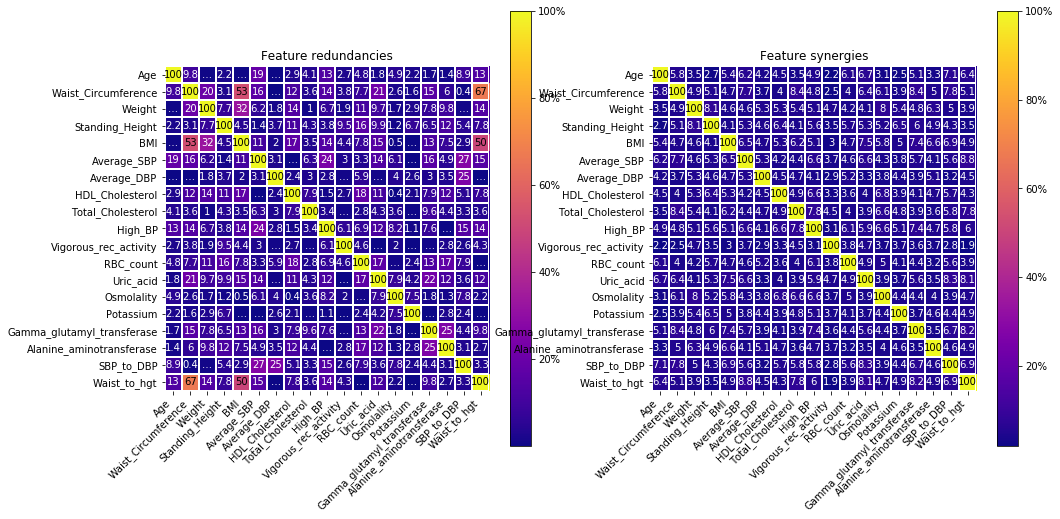

In [71]:
# redundancy and synergy heatmaps
plt.subplot(1, 2, 1)
MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Feature redundancies")
plt.subplot(1, 2, 2)
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Feature synergies")

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


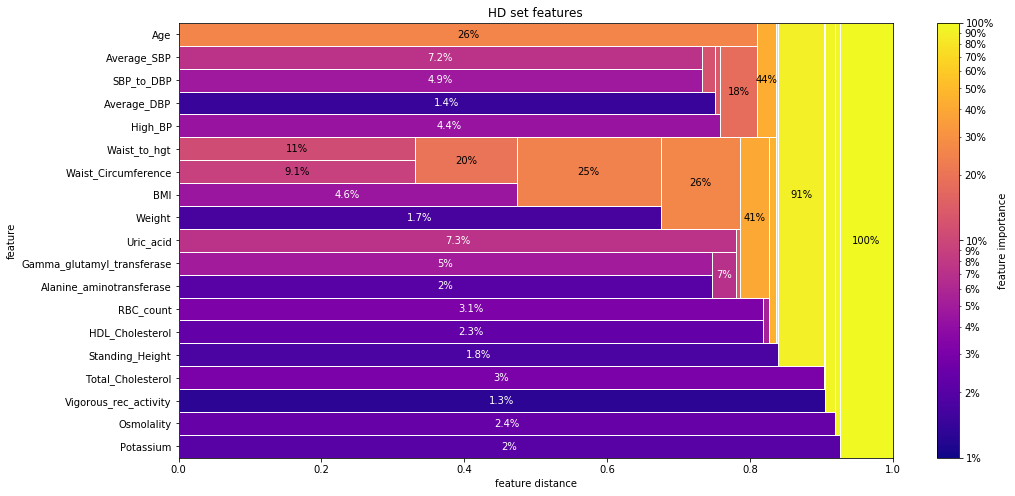

In [72]:
# Redundancy dendogram
DendrogramDrawer().draw(title="HD set features", data=dd_redundancy)

**What might we infer from the above information?**

1. Very clearly BMI, waist circumference and waist to height ratio form a small cluster of somewhat redundant variables. This makes sense for two reasons: the first is that waist circumference is included in the calculation of waist to height ratio, secondly, we would expect BMI to capture similar information about excess body mass as higher waist circumference and waist to height ratio.
2. Interestingly from the Synergy matrix we see little in the way of Synergy. We might have expected apriori to find some interesting synergies between diet, exercise, sleep and body composition. Of course, the model needs to find such things in order from them to be reflected in the Synergy metric.

**What action(s) might we take?**

1. Given the redundancy that appears between BMI, waist circumference and waist to height ratio, we could look to eliminate one or two of these features from the model. 

## Removing redundant features

Recall the redundancy dendogram above where we saw a clear cluster of features with redundancy; Waist_to_hgt, BMI, and Waist_Circumference.

- assess if the features of the model are unique, i.e. not redundant with other features
- decide which features to discard, combine, or modify to increase the uniqueness of important features in the model

Before we proceed to looking at SHAP values for individual predictions and perform a univariate simulation, let's eliminate two partially redundant features - we will choose to keep Waist_to_hgt ratio and drop BMI and waist_circumference. 

In [107]:
prediab = prediab.drop(['BMI', 'Waist_Circumference'])

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [113]:
# re-run without redundant features
ranker = LearnerRanker(
    grids=[rf_grid, gb_grid],
    cv=BootstrapCV(random_state=42),
    n_jobs=-3,
    scoring='roc_auc'
).fit(prediab)

# run inspector
inspector = LearnerInspector(
    n_jobs=-3,
    verbose=10,
).fit(
    crossfit=ranker.best_model_crossfit.resize(20)
)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


KeyboardInterrupt: 

In [ ]:
# obtain Facet feature importance, as well as synergy and redundancy matrices
f_importance = inspector.feature_importance()
redundancy_matrix = inspector.feature_redundancy_matrix()
synergy_matrix = inspector.feature_synergy_matrix()
dd_redundancy = inspector.feature_redundancy_linkage()

# Also let's get some info for standard SHAP plots!
shap_values = inspector.shap_values().to_numpy()
rf_pipeline.preprocessing.fit(X=prediab_new.features)
X_train = rf_pipeline.preprocessing.transform(X=prediab_new.features)
X_train = X_train.reset_index()[prediab_new.features.columns]

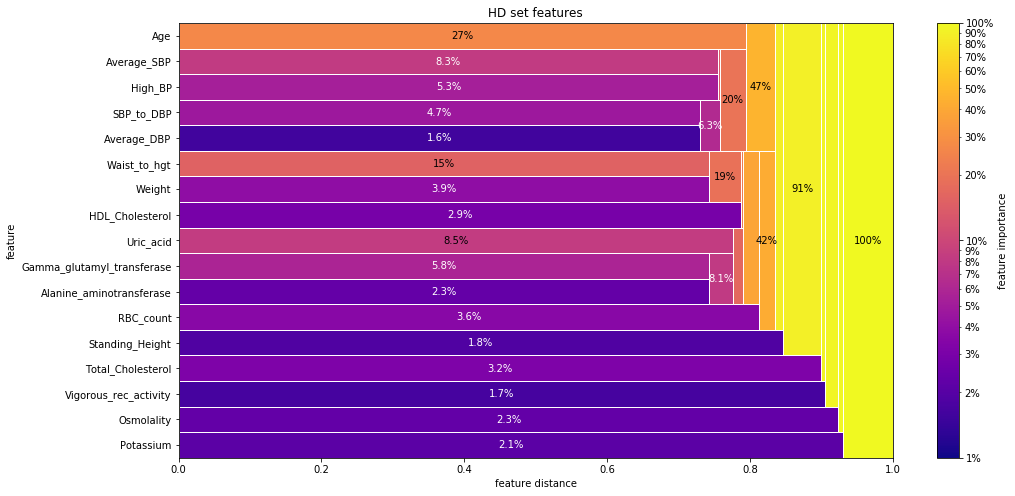

In [197]:
# Redundancy dendogram
DendrogramDrawer().draw(title="HD set features", data=dd_redundancy)

## Individual contributions to predictions

With SHAP values we can also look at how features contribute to individual predictions, so let us compare a patient at low and a patient at high risk of prediabetes using Waterfall plots. Note a similar understanding could be obtained from looking at force plots which also allows for a logit option to present probabilities.
For example: `shap.force_plot(base_value=base_value, shap_values=shap_values[2985,:], features=X_train.iloc[2985,:].round(2), matplotlib=True)`

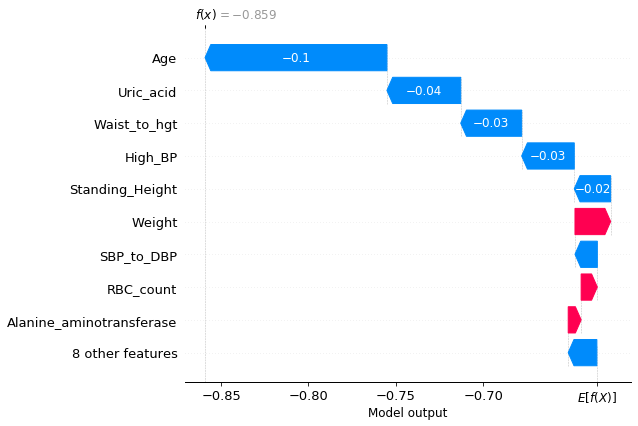

In [200]:
# The waterfall plot
base_value = np.log(prediab_new.target.mean()/(1-prediab_new.target.mean()))
shap.waterfall_plot(base_value, shap_values_1[2985,:], feature_names=X_train_1.columns.values, max_display=10, show=True)

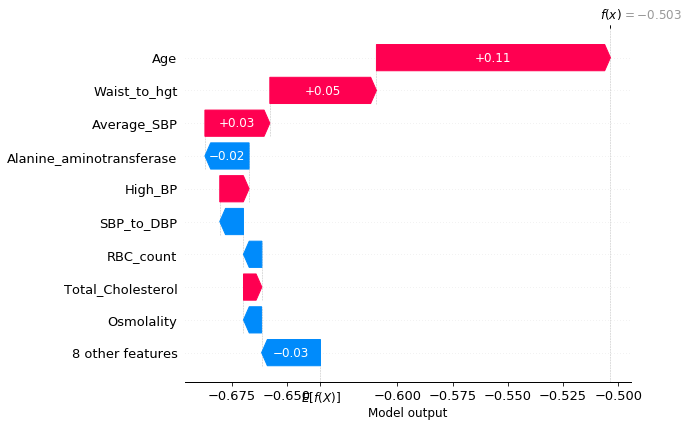

In [201]:
shap.waterfall_plot(base_value, shap_values_1[1294,:], feature_names=X_train_1.columns.values, max_display=10, show=True)

Based on the waterfall plots we can see for the low-risk patient example: we can see the largest contributions to decreased risk are younger age, low uric acid, low waist to height ratio and not having high BP.

Based on the waterfall plots we can see for the high-risk patient example: we can see the largest contributions to increased risk are a higher than average SBP, high waist to height ratio and older age.

## Univariate simulation for waist to height ratio (WIP)

The second advantage offered by facet is the ability to quickly instigate and run univariate simulation. 
Based on redundancy above let's remove BMI and waist circumference and look at waist to height ratio. The idea is that the simulation will help us to understand what value of this ratio might help to minimize the likelihood of being pre-diabetic.

In [204]:
sim_feature = "Age" # failed for Waist_to_hgt - due to missings?
simulator = UnivariateUpliftSimulator(crossfit=ranker_1.best_model_crossfit, n_jobs=-1)
partitioner = ContinuousRangePartitioner()

In [205]:
univariate_simulation = simulator.simulate_feature(name=sim_feature, partitioner=partitioner)

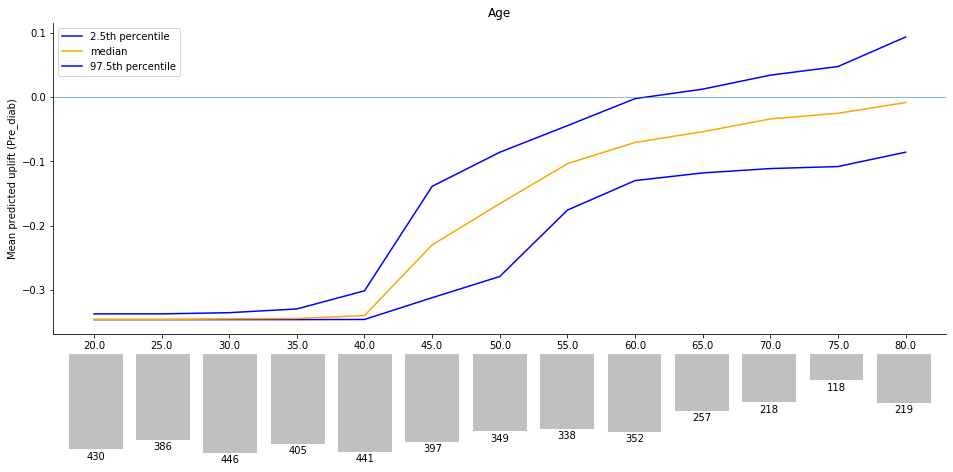

In [207]:
SimulationDrawer().draw(data=univariate_simulation, title=sim_feature)

In [206]:
SimulationDrawer("text").draw(data=univariate_simulation, title=sim_feature)

SIMULATION REPORT: Age

Mean predicted uplift (Pre_diab):

Partition  2.5th percentile  median     97.5th percentile
=========  ================  =========  =================
20                -0.346     -0.346             -0.337   
25                -0.346     -0.346             -0.337   
30                -0.346     -0.345             -0.336   
35                -0.346     -0.345             -0.33    
40                -0.346     -0.34              -0.302   
45                -0.312     -0.23              -0.139   
50                -0.279     -0.166             -0.0858  
55                -0.176     -0.104             -0.0444  
60                -0.13      -0.0705            -0.00232 
65                -0.118     -0.0538             0.0125  
70                -0.111     -0.034              0.0343  
75                -0.108     -0.0251             0.0477  
80                -0.0857    -0.00838            0.0937  

Observed frequencies:

Partition  Frequency
=========  =========
20   

As we can see the simulation shows...(discuss pattern and insights and max or min if there is one)

# Summary

With the capabilities offered by Facet we were able to:

1. Identify a learner using bootstrap CV with performance comparable to models in the literature.
2. Utilize advanced the SHAP value capabilities (synergy and redundancy) to identify additional features that could be removed (i.e., BMi and waist circumference remvoed in favor of waist to height ratio) and whether or not any features had strong synergistic effects - which they did not.
3. Simulate the effect of changes in waist to height ratio on the likelihood of being prediabetic.

# What can you do next?

There are a number of next/alternative steps that could be taken:

1. Utilize methods to deal with class imbalance and see if it improves the model.
2. Adding more features! The NHANES data is a treasure trove of information.
3. Retain diabetic patients and convert it into a multi-class learning problem.
4. What would happen if we applied survey weights when constructing a learner?
5. Further investigation of feature engineering. One could also look at different sets of measurements such as the bio-profile and perform dimension reduction first via PCA or some other method.
6. Other learners such as SVC, LDA, Elastic-Net, CNN.
7. More sophisticated imputation for missing values: the assumption of MAR might not hold, as those with worse health and thus more at risk of prediabetes may be more likely not to disclose poor health characteristics. Methods enabled by IterativeImputer could be used or even KNNImputer. Also feature engineering could be done post imputation in the pipeline, so values such as ratios are consistent. 